In [ ]:
import numpy as np # linear algebra
import os # accessing directory structure

import pydicom #for loading dicom
import scipy.ndimage

In [ ]:
# A helper funtion for loading dicom scans as nump arrays
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [ ]:
# Let's load one of the scans from Experiment 1
scan_uuid = 8038
scan, spacing, orientation, origin, raw_slices = load_dicom('/CT_Scans/EXP1_blind/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

The CT scan has the dimensions of (249, 512, 512)   (z,y,x)


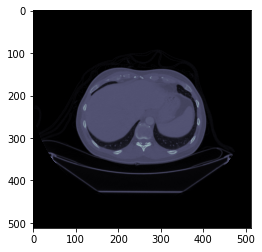

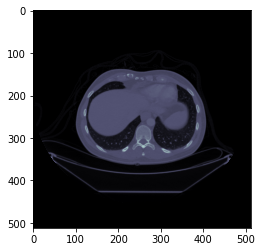

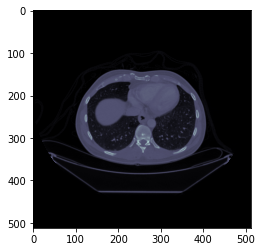

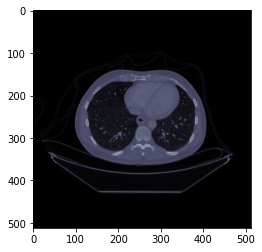

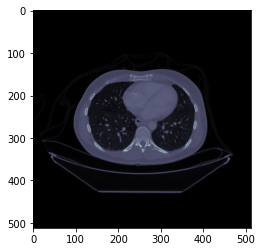

In [ ]:
# Now lets plot a few slices
from matplotlib import pyplot as plt

# Show a few slices along the body
for slice_indx in range(50,100,10):
    plt.imshow(scan[slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [ ]:
#import the labels for Experiment 1
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

exp1_labels = pd.read_csv('/labels_exp1.csv')

In [ ]:
#find the regions of interest in our scan 
locations = exp1_labels.loc[exp1_labels['uuid']==scan_uuid]
locations
#Note that this location is 'FM' (False Malign) so it's an injected cancer"

,type,uuid,slice,x,y
87,FM,8038,123,169,207


In [ ]:
# Let's cut a small cube out of this scan containing this fake cancer

# Here is the helper function
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)

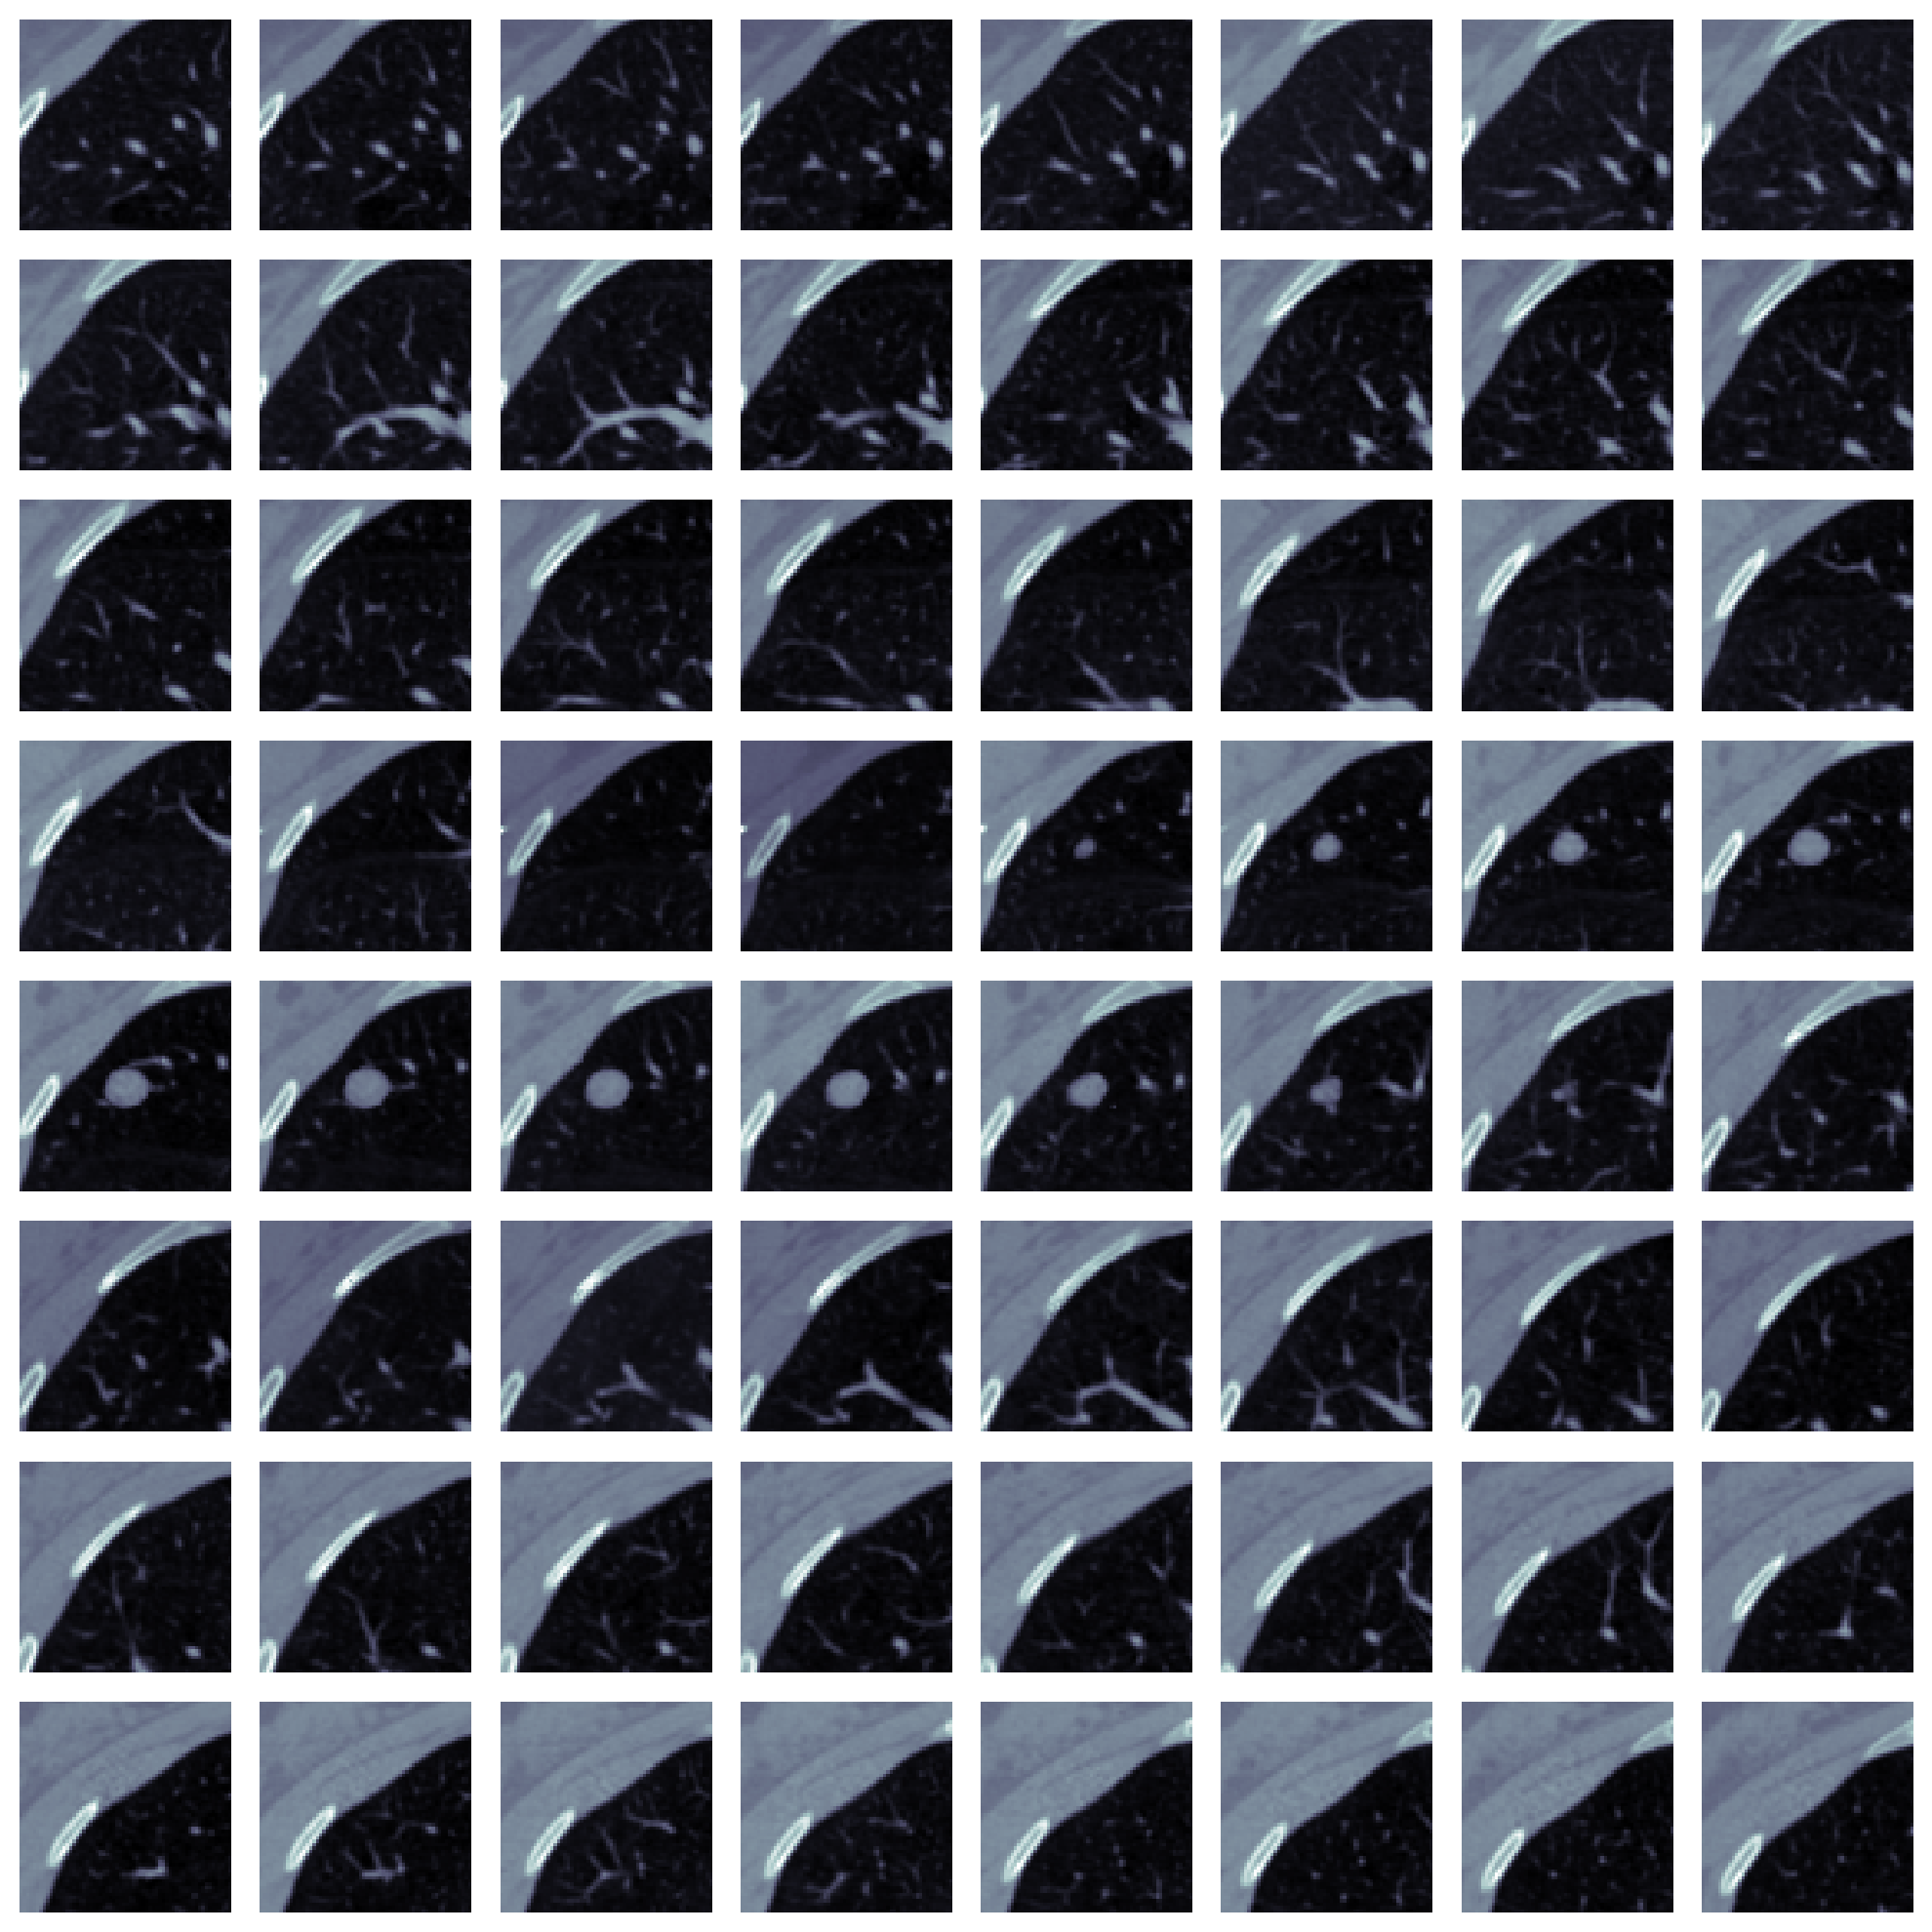

In [ ]:
#Here are the regions of interest:
cut_cubes = []
for i in range(len(locations)):
    location = locations.iloc[i]
    coord = np.array([location['slice'],location['y'],location['x']])
    cut_cubes.append(cutCube(scan,coord,(64,64,64)))

#disply the slices of each cut cube:
for cube in cut_cubes:
    plt.figure(num=None, figsize=(10, 10), dpi=200)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(cube[i,:,:],cmap='bone')
    plt.show()